In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
all_data = pd.read_csv('all_data.csv')

In [3]:
all_data['Bundesland'] = all_data.districtId // 1000
#Bundesland string didn't fit into the 25MB file limit 
#of Github for the rki_raw file

In [4]:
ferien_dict = {8:31,
               9:31,
               11:27,
               12:27,
               4:25,
               2:27,
               6:28,
               13:26,
               3:30,
               5:27,
               7:28,
               10:28,
               14:30,
               15:30,
               1:27,
               16:30}

summer_vac_df = pd.DataFrame()
offset=1
#offsetting the summer vacation by one week, even though performance measure/target already
#'looks' one week into the future, to include all travel-returners' effects. Could also be 0 or 2?

for bl,start in ferien_dict.items():
    ferien = [start+offset+no for no in range(0,6)]
    bl_data = all_data.loc[all_data.Bundesland==bl,['districtId','week_no']].copy()
    bl_data['summer_vac'] = bl_data.week_no.isin(ferien)
    summer_vac_df = summer_vac_df.append(bl_data)
    
all_data = pd.merge(all_data, summer_vac_df, how='outer')
    


In [5]:
def deviance_sum_interval(first_week, last_week):
    cut_data = all_data[all_data.week_no.between(first_week,last_week, inclusive=True)].copy()
    deviance_sums = cut_data.groupby('districtId')['deviance'].mean().reset_index()
    return deviance_sums

In [6]:
# wmin = all_data.week_no.min()
# wmax = all_data.week_no.max()
lockdown = deviance_sum_interval(12,21)
summer = all_data[all_data.summer_vac].groupby('districtId')['deviance'].mean().reset_index()
deviance_df = pd.merge(lockdown, summer,
                      on='districtId',how='outer',
                      suffixes=('_lockdown','_summer'))

In [7]:
deviance_df

,districtId,deviance_lockdown,deviance_summer
0,1001,0.063881,-0.250877
1,1002,0.335208,-0.169955
2,1003,0.320629,-0.190692
3,1004,0.187470,-0.134761
4,1051,0.065773,-0.172774
...,...,...,...
395,16073,0.107069,-0.147875
396,16074,0.096978,-0.408810
397,16075,-0.144700,-0.289974
398,16076,-0.084006,-0.135573


Correlation: 0.0632299466680943


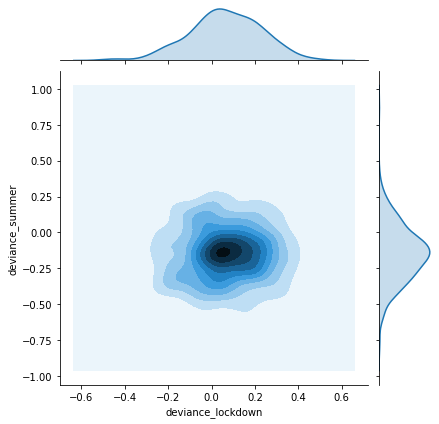

In [8]:
sns.jointplot(deviance_df.iloc[:,1],deviance_df.iloc[:,2],kind='kde')
print('Correlation:',np.corrcoef(deviance_df.iloc[:,1],deviance_df.iloc[:,2])[1,0])

In [9]:
def get_top_x(variable, x=10):
    return deviance_df.sort_values(variable,ascending=False).iloc[:x]

In [10]:
get_top_x('deviance_lockdown')

,districtId,deviance_lockdown,deviance_summer
99,5758,0.502227,-0.038247
211,8336,0.467533,0.050636
142,7111,0.444431,-0.173249
360,14713,0.428914,-0.294541
8,1056,0.420426,-0.020781
15,2000,0.400309,-0.091768
58,3460,0.389060,0.278868
261,9372,0.365634,0.087233
343,13004,0.361758,-0.145412
81,5334,0.361232,-0.243135


In [11]:
get_top_x('deviance_summer')

,districtId,deviance_lockdown,deviance_summer
256,9279,-0.003581,0.847217
307,9764,0.154574,0.407729
67,5116,0.335834,0.328138
42,3360,0.186341,0.323450
367,15082,-0.011327,0.313287
31,3256,0.122875,0.301983
58,3460,0.389060,0.278868
163,7316,0.034332,0.244944
98,5754,0.111310,0.236914
155,7232,0.226373,0.230897
